# Train AffectNet March2021
* Author: Sungguk Cha
* eMail: sungguk@ncsoft.com
* Date: 7 Nov. 2022

## Libraries

In [3]:
import copy
import glob
import sys
import os
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.metrics import plot_confusion_matrix
import timm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import transforms
from torchvision.models import resnet101, mobilenet_v2
from tqdm.notebook import tqdm


from robust_optimization import RobustOptimizer

print(f'Torch: {torch.__version__}')
print(f'Timm: {timm.__version__}')

Torch: 1.12.1
Timm: 0.6.11


## Training configurations

In [4]:
affectnet_dir = '../../../../datasets/affectnet'
backbone = 'efficientnet_b0'

In [3]:
# Training settings
batch_size = 32 #48# 32# 32 #16 #8 #
epochs = 40
lr = 3e-5
gamma = 0.7
seed = 42
device = 'cuda'
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


In [4]:
IMG_SIZE=260 if 'b2' in backbone else 224 # 300 # 80 #
train_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)
print(test_transforms)

Compose(
    Resize(size=(260, 260), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [5]:
kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}

## AffectNet Dataloader

In [6]:
class AffectNet(data.Dataset):
    def __init__(self, aff_path, phase, use_cache=True, transforms=None, force=False):
        self.phase = phase
        self.transforms = transforms
        self.aff_path = aff_path
        self.base_path = os.path.join(self.aff_path, f'{self.phase}_set/')
        
        if use_cache:
            cache_path = os.path.join(aff_path,f'affectnet_{phase}.csv')
            if os.path.exists(cache_path) and not force:
                df = pd.read_csv(cache_path)
            else:
                df = self.get_df()
                df.to_csv(cache_path)
        else:
            df = self.get_df()

        self.data = df[df['phase'] == phase]

        self.file_paths = self.data.loc[:, 'img_path'].values
        self.label = self.data.loc[:, 'label'].values

        self.emotion_labels=['Neutral','Happiness', 'Sadness', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt']
        sample_label, sample_counts = np.unique(self.label, return_counts=True)
        for l, c in zip(sample_label, sample_counts):
            print(f'{self.emotion_labels[l]}: {c} ', end='')
        print(f'\n{len(self)} images')

    def get_df(self):
        data = []
        
        for anno in glob.glob(self.base_path + 'annotations/*_exp.npy'):
            idx = os.path.basename(anno).split('_')[0]
            img_path = f'images/{idx}.jpg'
            label = int(np.load(anno))
            data.append([self.phase,img_path,label])
        
        return pd.DataFrame(data = data,columns = ['phase','img_path','label'])

    def get_weight(self):
        self.emotion_labels=['Neutral','Happiness', 'Sadness', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt']
        self.class_to_idx = {}
        self.idx_to_class = {}
        for i, emotion in enumerate(self.emotion_labels):
            self.class_to_idx[emotion] = i
            self.idx_to_class[i] = emotion
        sample_label, sample_counts = np.unique(self.label, return_counts=True)
        for l, c in zip(sample_label, sample_counts):
            print(f'{self.emotion_labels[l]}: {c} ', end='')
        print('')
        
        cw = 1/sample_counts
        cw /= cw.min()
        class_weights = {i:cwi for i, cwi in zip(sample_label, cw)}
        print(class_weights)
        return class_weights

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = os.path.join(self.base_path, self.file_paths[idx])
        image = Image.open(path).convert('RGB')
        label = self.label[idx]

        if self.transforms is not None:
            image = self.transforms(image)
        
        return image, label

In [7]:
trainset = AffectNet(affectnet_dir, 'train', transforms=train_transforms, force=False)
valset = AffectNet(affectnet_dir, 'val', transforms=test_transforms)
trainloader = data.DataLoader(trainset, batch_size=batch_size, shuffle=True, **kwargs)
valloader = data.DataLoader(valset, batch_size=batch_size, shuffle=False, **kwargs)


287651 images

3999 images


In [8]:
class_weights = trainset.get_weight()

Neutral: 74874 Happiness: 134415 Sadness: 25459 Surprise: 14090 Fear: 6378 Disgust: 3803 Anger: 24882 Contempt: 3750 
{0: 1.7952159628175335, 1: 1.0, 2: 5.279665344279037, 3: 9.539744499645138, 4: 21.07478833490122, 5: 35.34446489613463, 6: 5.402097902097902, 7: 35.844}


## Functions

In [9]:
#adapted from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
def set_parameter_requires_grad(model, requires_grad):
    for param in model.parameters():
        param.requires_grad = requires_grad

In [10]:
# loss function
weights = torch.FloatTensor(list(class_weights.values())).cuda()

def label_smooth(target, n_classes: int, label_smoothing=0.1):
    # convert to one-hot
    batch_size = target.size(0)
    target = torch.unsqueeze(target, 1)
    soft_target = torch.zeros((batch_size, n_classes), device=target.device)
    soft_target.scatter_(1, target, 1)
    # label smoothing
    soft_target = soft_target * (1 - label_smoothing) + label_smoothing / n_classes
    return soft_target

def cross_entropy_loss_with_soft_target(pred, soft_target):
    #logsoftmax = nn.LogSoftmax(dim=-1)
    return torch.mean(torch.sum(- weights*soft_target * torch.nn.functional.log_softmax(pred, -1), 1))

def cross_entropy_with_label_smoothing(pred, target):
    soft_target = label_smooth(target, pred.size(1)) #num_classes) #
    return cross_entropy_loss_with_soft_target(pred, soft_target)

criterion=cross_entropy_with_label_smoothing

In [11]:
def train(model,n_epochs=epochs, learningrate=lr, robust=False):
    # optimizer
    if robust:
        optimizer = RobustOptimizer(filter(lambda p: p.requires_grad, model.parameters()), optim.Adam, lr=learningrate)
        #print(optimizer)
    else:
        optimizer=optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learningrate)
    # scheduler
    #scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
    best_acc=0
    best_model=None
    for epoch in range(n_epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        model.train()
        for data, label in tqdm(trainloader):
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            loss = criterion(output, label)

            if robust:
                #optimizer.zero_grad()
                loss.backward()
                optimizer.first_step(zero_grad=True)
  
                # second forward-backward pass
                output = model(data)
                loss = criterion(output, label)
                loss.backward()
                optimizer.second_step(zero_grad=True)
            else:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            acc = (output.argmax(dim=1) == label).float().sum()
            epoch_accuracy += acc
            epoch_loss += loss
        epoch_accuracy /= len(trainset)
        epoch_loss /= len(trainset)
        
        model.eval()
        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in valloader:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().sum()
                epoch_val_accuracy += acc
                epoch_val_loss += val_loss
        epoch_val_accuracy /= len(valset)
        epoch_val_loss /= len(valset)
        print(
            f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        )
        if best_acc<epoch_val_accuracy:
            best_acc=epoch_val_accuracy
            best_model=copy.deepcopy(model.state_dict())
        #scheduler.step()
    
    if best_model is not None:
        model.load_state_dict(best_model)
        print(f"Best acc:{best_acc}")
        model.eval()
        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in valloader:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().sum()
                epoch_val_accuracy += acc
                epoch_val_loss += val_loss
        epoch_val_accuracy /= len(valset)
        epoch_val_loss /= len(valset)
        print(
            f"val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        )
    else:
        print(f"No best model Best acc:{best_acc}")

## Train

In [12]:
model = timm.create_model('tf_efficientnet_b0_ns', pretrained=False)
model.classifier=torch.nn.Identity()
model.load_state_dict(torch.load('../../models/pretrained_faces/state_vggface2_enet0_new.pt')) #_new

<All keys matched successfully>

In [13]:
num_classes = len(trainset.emotion_labels)
model.classifier = nn.Sequential(nn.Linear(in_features=1280, out_features=num_classes)) #1792 #1280 #1536
#model.head.fc=nn.Linear(in_features=3072, out_features=num_classes)
#model.head=nn.Sequential(nn.Linear(in_features=768, out_features=num_classes))
model=model.to(device)
print(model)

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=

In [14]:
set_parameter_requires_grad(model, requires_grad=False)
set_parameter_requires_grad(model.classifier, requires_grad=True)
train(model,3,0.001,robust=True)
#Best val acc:0.5114

  0%|          | 0/8990 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.2766 - acc: 0.3107 - val_loss : 0.5862 - val_acc: 0.4836



  0%|          | 0/8990 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.2710 - acc: 0.3340 - val_loss : 0.5987 - val_acc: 0.4546



  0%|          | 0/8990 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.2700 - acc: 0.3389 - val_loss : 0.6381 - val_acc: 0.4806

Best acc:0.48362094163894653
val_loss : 0.5862 - val_acc: 0.4836



In [15]:
set_parameter_requires_grad(model, requires_grad=True)
train(model,6,1e-4,robust=True)

  0%|          | 0/8990 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.2447 - acc: 0.4401 - val_loss : 0.5437 - val_acc: 0.5911



  0%|          | 0/8990 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.2302 - acc: 0.5295 - val_loss : 0.4955 - val_acc: 0.6027



  0%|          | 0/8990 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.2239 - acc: 0.5622 - val_loss : 0.5045 - val_acc: 0.6054



  0%|          | 0/8990 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.2194 - acc: 0.5829 - val_loss : 0.5144 - val_acc: 0.6239



  0%|          | 0/8990 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.2150 - acc: 0.6004 - val_loss : 0.5152 - val_acc: 0.6157



  0%|          | 0/8990 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.2104 - acc: 0.6163 - val_loss : 0.5231 - val_acc: 0.6227

Best acc:0.6239060163497925
val_loss : 0.5144 - val_acc: 0.6239



In [5]:
PATH = f'../../models/affectnet_emotions/affectnet_march2021_{backbone}.pt'

In [17]:
# Save
torch.save(model, PATH)

In [18]:
# Load
print(PATH)
model = torch.load(PATH)
model = model.eval()

../models/affectnet_emotions/enet_b2_8_best.pt


In [19]:
class_to_idx = trainset.class_to_idx
print(class_to_idx)
idx_to_class = trainset.idx_to_class
print(idx_to_class)

{'Neutral': 0, 'Happiness': 1, 'Sadness': 2, 'Surprise': 3, 'Fear': 4, 'Disgust': 5, 'Anger': 6, 'Contempt': 7}
{0: 'Neutral', 1: 'Happiness', 2: 'Sadness', 3: 'Surprise', 4: 'Fear', 5: 'Disgust', 6: 'Anger', 7: 'Contempt'}


In [21]:
y_val,y_scores_val=[],[]
model.eval()
            
for image, label in valset:
    image.unsqueeze_(0)
    image = image.cuda()
    scores = model(image)
    scores = scores[0].data.cpu().numpy()
    y_scores_val.append(scores)
    y_val.append(label)

y_scores_val=np.array(y_scores_val)
y_val=np.array(y_val)
print(y_scores_val.shape,y_val.shape)

(3999, 8) (3999,)


In [22]:
y_pred=np.argmax(y_scores_val,axis=1)
acc=100.0*(y_val==y_pred).sum()/len(y_val)
print(acc)

y_train=np.array(trainset.label)

for i in range(y_scores_val.shape[1]):
    _val_acc=(y_pred[y_val==i]==i).sum()/(y_val==i).sum()
    print('%s %d/%d acc: %f' %(idx_to_class[i],(y_train==i).sum(),(y_val==i).sum(),100*_val_acc))

62.34058514628657
Neutral 74874/500 acc: 50.000000
Happiness 134415/500 acc: 72.600000
Sadness 25459/500 acc: 52.800000
Surprise 14090/500 acc: 67.800000
Fear 6378/500 acc: 63.200000
Disgust 3803/500 acc: 65.000000
Anger 24882/500 acc: 57.800000
Contempt 3750/499 acc: 69.539078


In [26]:
#-Contempt
contempt_idx=class_to_idx['Contempt']
y_scores_val_filtered=y_scores_val[:, [i!=contempt_idx for i in idx_to_class]]
print(y_scores_val_filtered.shape)
y_pred_filtered=np.argmax(y_scores_val_filtered,axis=1)
other_indices=y_val!=contempt_idx
y_val_new=np.array([y if y<contempt_idx else y-1 for y in y_val if y!=contempt_idx])
acc=100.0*np.mean(y_val_new==y_pred_filtered[other_indices])
print(acc)

(3999, 7)
65.57142857142857


['Neutral', 'Happiness', 'Sadness', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt']
(3999,) (3999,) 0.6234058514628658


C:\Users\sungguk\.conda\envs\emotion\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


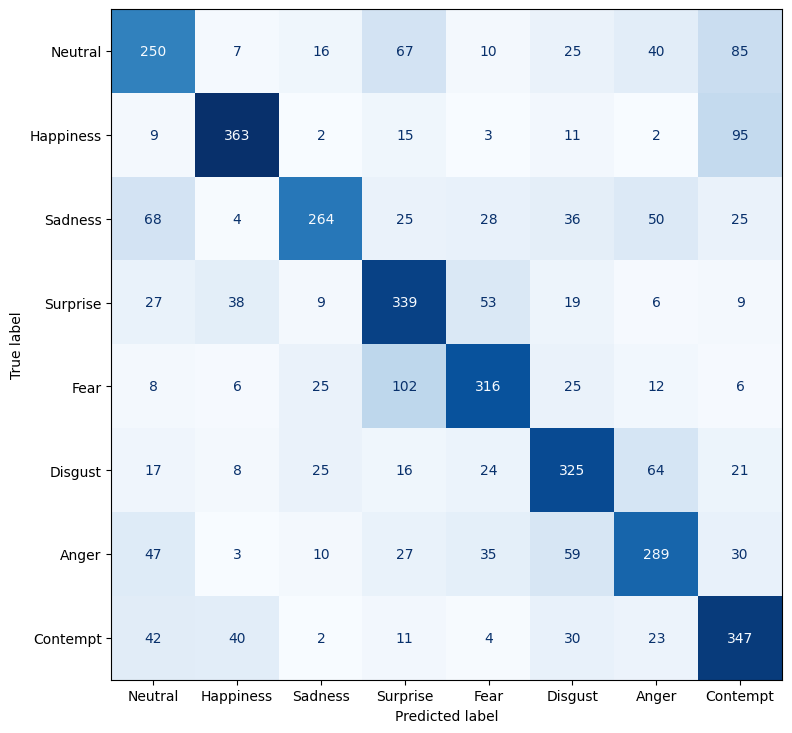

In [27]:
labels=list(class_to_idx.keys())
print(labels)
IC = type('IdentityClassifier', (), {"predict": lambda i : i, "_estimator_type": "classifier"})
def plt_conf_matrix(y_true,y_pred,labels):
    print(y_pred.shape,y_true.shape, (y_pred==y_true).mean())

    fig, ax = plt.subplots(figsize=(8, 8))
    plot_confusion_matrix(IC, y_pred,y_true,display_labels=labels,cmap=plt.cm.Blues,ax=ax,colorbar=False) #,normalize='true'
    plt.tight_layout()
    plt.show()
plt_conf_matrix(y_val,y_pred,labels)

['Neutral', 'Happiness', 'Sadness', 'Surprise', 'Fear', 'Disgust', 'Anger']
(3500,) (3500,) 0.6557142857142857


C:\Users\sungguk\.conda\envs\emotion\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


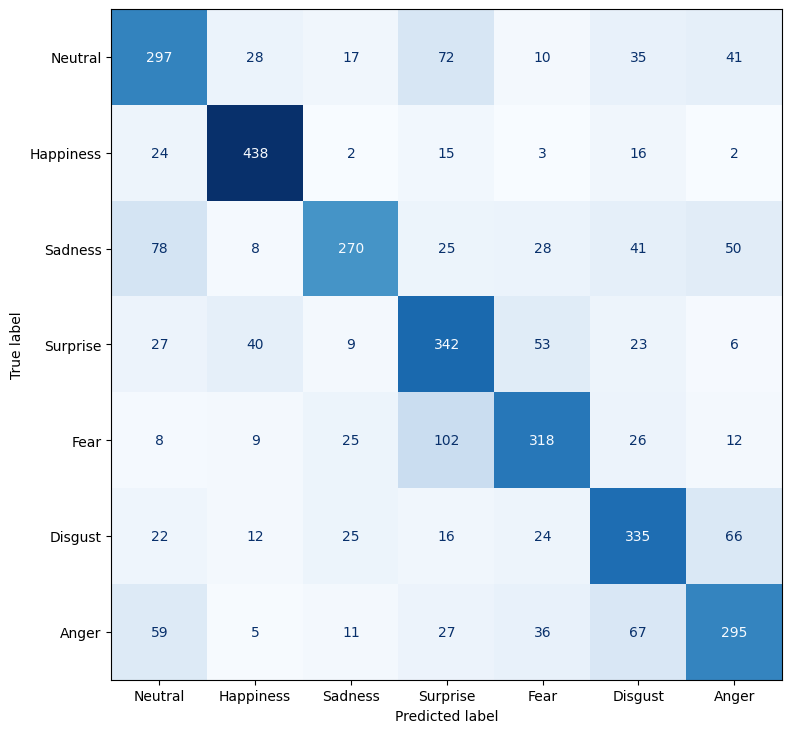

In [29]:
labels_7=[idx_to_class[i] for i in idx_to_class if i!=contempt_idx]#list(class_to_idx.keys())
print(labels_7)
plt_conf_matrix(y_val_new, y_pred_filtered[other_indices],labels_7)